<a href="https://colab.research.google.com/github/yejikwon7/DeepLearning/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

(x_train,y_train),(x_test,y_test)=keras.datasets.cifar10.load_data()

n_class=10                      # 부류 수
img_siz=(32,32,3)               # 영상의 크기

patch_siz=4                     # 패치 크기
p2=(img_siz[0]//patch_siz)**2   # 패치 개수

# patch 늘림
# img_expanded_siz=(72, 72, 3)

# patch_siz=6
# p2=(img_expanded_siz[0]//patch_siz)**2

d_model=64                      # 임베딩 벡터 차원, 하나의 patch당
h=8                             # 헤드 개수
N=6                             # 인코더 블록의 개수, layer 6개

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.p_siz=patch_size

    def call(self, img):
        batch_size=tf.shape(img)[0]
        patches=tf.image.extract_patches(images=img, sizes=[1,self.p_siz,self.p_siz,1], strides=[1,self.p_siz,self.p_siz,1], rates=[1,1,1,1], padding='VALID')
          # patch 추출
          # stride: 겹치는 부분 없이 patch 생성
        patch_dims=patches.shape[-1]
        patches=tf.reshape(patches, [batch_size,-1,patch_dims])
        return patches

class PatchEncoder(layers.Layer): # 임베딩 벡터 생성
    def __init__(self,p2,d_model): # p2: 패치 개수
        super(PatchEncoder,self).__init__()
        self.p2=p2
        self.projection=layers.Dense(units=d_model) # dimension size만큼 patch 임베딩
        self.position_embedding=layers.Embedding(input_dim=p2,output_dim=d_model) # 정수화된 것을 d_model 크기만큼 위치 임베딩

    def call(self,patch):
        positions=tf.range(start=0,limit=self.p2,delta=1) # positoin 산정
        encoded=self.projection(patch)+self.position_embedding(positions) # 같은 크기이므로 더함
        return encoded

In [ ]:
def create_vit_classifier(): # 모델 정의
    input=layers.Input(shape=(img_siz)) # train 데이터
    nor=layers.Normalization()(input) # input data에 대한 norm.

    # size 확대
    # exp=layers.Resizing(img_expanded_siz[0], img_expanded_siz[1])(nor)

    # x=layers.RandomFlip('horizontal')(exp)
    # x=layers.RandomRotation(factor=0.02)(x)
    # x=layers.RandomZoom(height_factor=0.2, width_factor=0.2)(x)

    patches=Patches(patch_siz)(nor) # 패치 생성
    x=PatchEncoder(p2,d_model)(patches) # 패치 인코딩

    for _ in range(N): # 다중 인코더 블록
        x1=layers.LayerNormalization(epsilon=1e-6)(x) # 층 정규화
        x2=layers.MultiHeadAttention(num_heads=h, key_dim=d_model//h, dropout=0.1)(x1,x1) # MHA
        x3=layers.Add()([x2,x]) # 지름길 연결, residual connection
        x4=layers.LayerNormalization(epsilon=1e-6)(x3) # 층 정규화
        x5=layers.Dense(d_model*2,activation=tf.nn.gelu)(x4) # MLP, 늘림
        x6=layers.Dropout(0.1)(x5)
        x7=layers.Dense(d_model,activation=tf.nn.gelu)(x6) # MLP, 복원
        x8=layers.Dropout(0.1)(x7)
        x=layers.Add()([x8,x3]) # 지름길 연결

    x=layers.LayerNormalization(epsilon=1e-6)(x)
    x=layers.Flatten()(x)
    x=layers.Dropout(0.5)(x)
    x=layers.Dense(2048,activation=tf.nn.gelu)(x)
    x=layers.Dropout(0.5)(x)
    x=layers.Dense(1024,activation=tf.nn.gelu)(x) # 줄임
    x=layers.Dropout(0.5)(x)
    output=layers.Dense(n_class,activation='softmax')(x) # 클래스 개수만큼 만듦

    model=keras.Model(inputs=input,outputs=output)
    return model

    # class_token 사용X, 전체 데이터 가져와 사용

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 110ms/step - accuracy: 0.3049 - loss: 2.1827 - val_accuracy: 0.5054 - val_loss: 1.3360
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.4768 - loss: 1.4464 - val_accuracy: 0.5779 - val_loss: 1.1976
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.5416 - loss: 1.2762 - val_accuracy: 0.6161 - val_loss: 1.0914
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.5859 - loss: 1.1578 - val_accuracy: 0.6488 - val_loss: 1.0037
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.6257 - loss: 1.0540 - val_accuracy: 0.6705 - val_loss: 0.9490
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.6556 - loss: 0.9811 - val_accuracy: 0.6826 - val_loss: 0.9071
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.6801 - loss: 0.9005 - val_accuracy: 0.7013 - val_loss: 0.8609
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.7011 - loss: 0.8470 - val

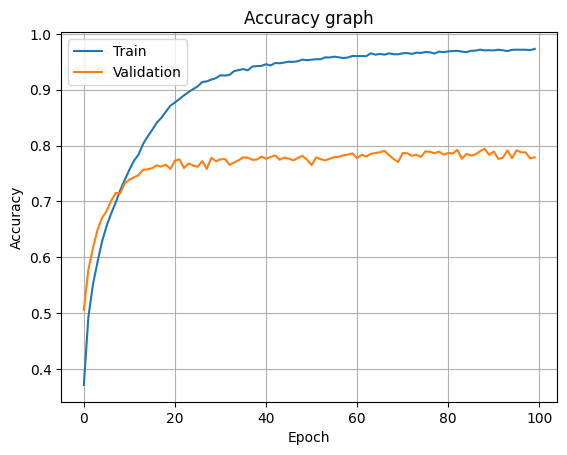

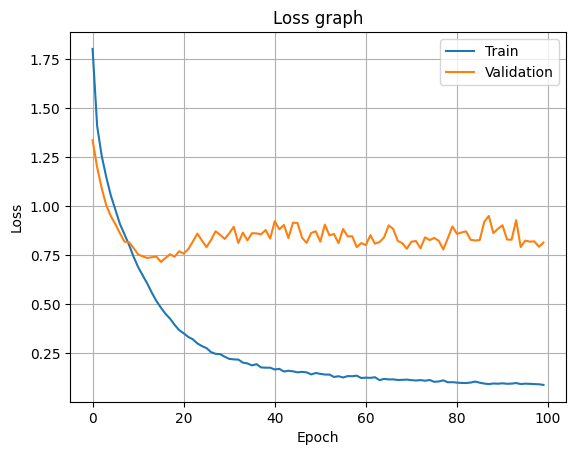

In [ ]:
model=create_vit_classifier()
model.layers[1].adapt(x_train) # 데이터 넣음

model.compile(optimizer=Adam(),loss=SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy']) #0~9 클래스
hist=model.fit(x_train,y_train,batch_size=128,epochs=100,validation_data=(x_test,y_test),verbose=1)

res=model.evaluate(x_test,y_test,verbose=0) # 평가: 정확도 수치
print('정확률=',res[1]*100)

import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy graph')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()